# Resynchronization des traces - (Jitter 1 of CW Board FW)

Nous savons que le side-channel est efficace pour attaquer une implémentation cryptographique. Toutefois, les fabricants de semi-conducteurs ont la volonté de rendre le plus complexe possible les attaques. Ils vont ajouter, notamment dans leur code, des contre-mesures comme l'ajout de gigue. 

------------
We have been collecting traces of our usual implementation of AES in this lab, with one small modification. If we use the EXTRA_OPTS=ADD_JITTER, a for loop that runs between 0 and 15 times through will be inserted:

```C
  #ifdef ADD_JITTER
  for (volatile uint8_t k = 0; k < (*pt & 0x0F); k++);
  #endif
```

As you can see, this jitter is actually based on the first byte of our plaintext. This in itself is a vulnerability. We won't use this fact, but as an exercise, try hypothocizing some ways to use this to overcome the jitter.

------------

**Aims**
- Observer l'efficacité de la contre-mesure
- Resynchroniser des traces

**Plan**
1. Import packages
2. Loading & plotting data
3. Trying CPA reverse on desynchronized traces
4. Resynchronization of traces
5. Trying CPA on synchronized traces


<img src='images/DoIt.png' style='width: 100px'>

# import

In [7]:
import warnings
import estraces
import numpy as np
import matplotlib.pyplot as plt
import time
import scared
from scipy.signal import find_peaks
import tqdm

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [20, 5]

# Collect traces from the Chipwhisperer (optional)

**If you have a ChipWhisperer**, you can collect the traces needed for this lab. If **you do not have the necessary equipment**, proceed to the next title `Loading & plotting datas`.

## Setup your chipwhisperer
---
To collect traces with Chipwhisperer (cw), you'll need to select a `SCOPETYPE`, a `PLATFORM`, and a `CRYPTO_TARGET`.
* `SCOPETYPE` is `'OPENADC'` for the CWLite
* `PLATFORM` is the target device, with `'CWLITEARM'`
* `CRYPTO_TARGET` selects the crypto implementation, with `'TINYAES128C'` working on all platforms.

```python
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'
```

In [1]:
# Define the values for the following constants
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'

### 🫵 Your turn: Setup your cw by using `Setup_Scripts/Setup_Generic.ipynb`

In [2]:
#%run "../chipwhisperer/chipwhisperer-jupyter/Setup_Scripts/Setup_Generic.ipynb"
%run "../../Jupyter3/chipwhisperer/jupyter/Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


### 🫵 Your turn: Using the cross-compiler, compile the vulnerable AES code for your victim processor. Don't forget the option `EXTRA_OPTS=ADD_JITTER`

In [3]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
#cd ../chipwhisperer/firmware/mcu/simpleserial-aes
cd ../../Jupyter3/chipwhisperer/hardware/victims/firmware/simpleserial-aes

make PLATFORM=$1 CRYPTO_TARGET=$2 EXTRA_OPTS=ADD_JITTER SS_VER=$3

Building for platform CWLITEARM with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
/Library/Developer/CommandLineTools/usr/bin/make clean_objs .dep 
Building for platform CWLITEARM with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
rm -f -- simpleserial-aes-CWLITEARM.hex
rm -f -- simpleserial-aes-CWLITEARM.eep
rm -f -- simpleserial-aes-CWLITEARM.cof
rm -f -- simpleserial-aes-CWLITEARM.elf
rm -f -- simpleserial-aes-CWLITEARM.map
rm -f -- simpleserial-aes-CWLITEARM.sym
rm -f -- simpleserial-aes-CWLITEARM.lss
rm -f -- objdir-CWLITEARM/*.o
rm -f -- objdir-CWLITEARM/*.lst
rm -f -- simpleserial-aes.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s aes.s aes-independant.s
rm -f -- simpleserial-aes.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d aes.d aes-independant.d
rm -f -- simpleserial-aes.i simpleserial.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sy

simpleserial-aes.c: In function 'get_pt':
simpleserial-aes.c:44:3: warning: this 'for' clause does not guard... [-Wmisleading-indentation]
   44 |   for (volatile uint8_t k = 0; k < (*pt & 0x0F); k++);
      |   ^~~
simpleserial-aes.c:47:2: note: ...this statement, but the latter is misleadingly indented as if it were guarded by the 'for'
   47 |  aes_indep_enc(pt); /* encrypting the data block */
      |  ^~~~~~~~~~~~~


### 🫵 Your turn: Load the vulnerable AES with jitter 1 onto the victim processor.

In [4]:
#cw.program_target(scope, prog, "../chipwhisperer/firmware/mcu/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))
cw.program_target(scope, prog, "../../Jupyter3/chipwhisperer/hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6283 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6283 bytes


---
Your chipwhisperer is ready !
## Run an AES computation and collect the power trace
### 🫵 Your turn: Execute the AES on your victim processor

💻[cw documentation](https://chipwhisperer.readthedocs.io/en/latest/scope-api.html)

> 💡**Tips**: Follow these steps to run AES and launch the scope.
> - Generate key, plain
> - set_key on target
> - write the plain onto the target with simpleserial_write and 'p' parameter
> - Define the number of samples to collect into the trace
> - Arm the scope for trace acquisition
> - Run the AES
> - Get the result (ciphertext) from the target with simpleserial_read and 'r' parameter
> - store the trace collected frome the scope with get_last_trace

In [5]:
ktp = cw.ktp.Basic()

In [8]:
# Generate plaintext and key for the AES execution
key, plaintext = ktp.next()

# Set the AES key for the target
target.set_key(key)

# Send the plaintext to encrypt
target.simpleserial_write('p', plaintext)

# Define the number of samples to collect into the trace
scope.adc.samples = 5_000

# Arm the scope for trace acquisition
scope.arm()

# Run the AES
ret = scope.capture()
if ret:
    print("Target timed out!")

#Store the result
ciphertext_returned = np.array(target.simpleserial_read('r', 16))

#Store the trace collected
trace = np.array(scope.get_last_trace())

### 🫵 Your turn: Print the ciphertext

In [9]:
ciphertext_returned

array([240,   7, 221, 167, 154, 194, 175, 148, 118, 203, 158, 116, 152,
       250, 213,  58], dtype=uint8)

### 🫵 Your turn: Plot the trace captured

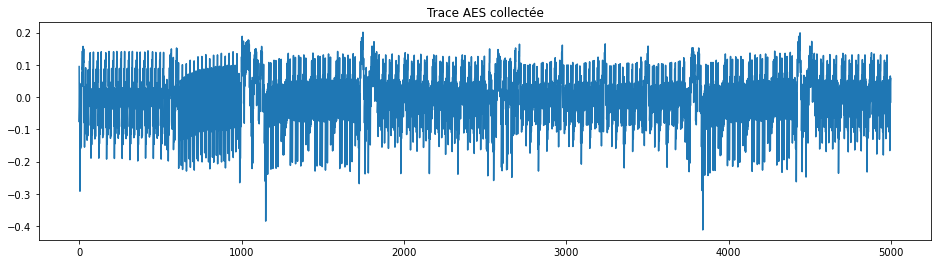

In [10]:
plt.rcParams['figure.figsize']=(16,4)
plt.title('Trace AES collectée')
plt.plot(trace)
plt.show()

### 🫵 Your turn: Using the previous cell to collect 2'000 traces

In [11]:
from tqdm import tnrange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []
keyin_array = []
response_array = []

key, text = ktp.next()

target.set_key(key)

scope.adc.samples = 8_000
#scope.adc.samples = 24_000


# Number of traces
#N = 2500
N = 100

# Loop for traces collection 
for i in tnrange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    keyin_array.append(key)
    response_array.append(response)
    
    key, text = ktp.next() 

# Loading & plotting datas

------------
------------

# IF you have a ChipWhisperer and you have collect the traces skip only this cell.


### 🫵 Your turn: Import the ets file `TP_2_CWLite_AES_traces_set_misaligned.ets`

In [4]:
ths = estraces.read_ths_from_ets_file('../SideSCA-Traces-Public/TP_2_CWLite_AES_traces_set_misaligned.ets')
print(ths)

Trace Header Set:
Name.............: ETS Format THS
Reader...........: ETS format reader of file ../SideSCA-Traces-Public/TP_2_CWLite_AES_traces_set_misaligned.ets with 100 traces.
ciphertext.......: uint8
key..............: uint8
plaintext........: uint8



In [5]:
textin_array = ths.plaintext
keyin_array = ths.key
response_array = ths.ciphertext
trace_array = ths.samples

---------------

## END OF CELL FOR NO CW 

---------------

### 🫵 Your turn: Display information contains in ets file

### 🫵 Your turn: Plot a trace contains in the ets file

💻[matplotlib documentation](https://numpy.org/devdocs/user/absolute_beginners.html)

❓Questions
- Do you recognize AES in the trace?

In [24]:
# create an array with the ths for each element (sample, ciphertext, plaintext, key)

In [1]:
# verify that the shapes of the arrays are the same (only for cipher, plain and key)

In [5]:
#%matplotlib
# plot one trace

### 🫵 Your turn: Plot 10 traces and their first 1'000 points

You can see that the traces are out of sync with each other. This is due to the addition of jitter.

In [4]:
#plot 10 traces

### 🫵 Your turn
-----------
## Test mean and variance on traces: what do you observe compare to the same test on the synchronized traces?

### Compute the mean and the standard deviation on the set of collected traces

In [ ]:
plt.rcParams['figure.figsize']=(16,8)

trace_mean = 

trace_std = 

plt.subplot(2,1,1) 
plt.plot(trace_mean)
plt.subplot(2,1,2) 
plt.plot(trace_std)
plt.show()

# Trying CPA reverse on desynchronized traces

### 🤓☝️ Remember
The `CPA reverse` allows to determine if an operation in an AES in a round, in this case, is vulnerable to a CPA attack.

The desynchronization of the traces may have blocked the CPA attack. We must try the reverse CPA to see if it is possible to attack the traces directly.

### 🫵 Your turn: Do the reverse on the output of SB in the first round:

💻[scared documentation](https://eshard.gitlab.io/scared/api_reference/analysis/reverse.html)

#### Use this open source SCA tool to analyse the trace with side-channel reverse engineering

In [9]:
import estraces

In [10]:
plaintext_np_array = np.array(textin_array)
plaintext_np_array.shape

(100, 16)

In [11]:
ciphertext_np_array = np.array(response_array)
ciphertext_np_array.shape

(100, 16)

In [12]:
key_np_array = np.array(keyin_array)
key_np_array.shape

(100, 16)

In [13]:
traces_np_array = np.array(trace_array)
traces_np_array.shape

(100, 8000)

In [14]:
ths = estraces.read_ths_from_ram(samples=traces_np_array, **{'plaintext': plaintext_np_array, 'ciphertext': ciphertext_np_array, 'key' : key_np_array})
print(ths)

Trace Header Set:
Name.............: RAM Format THS
Reader...........: RAM reader with 100 traces. Samples shape: (100, 8000) and metadatas: ['plaintext', 'ciphertext', 'key']
plaintext........: uint8
ciphertext.......: uint8
key..............: uint8



[]

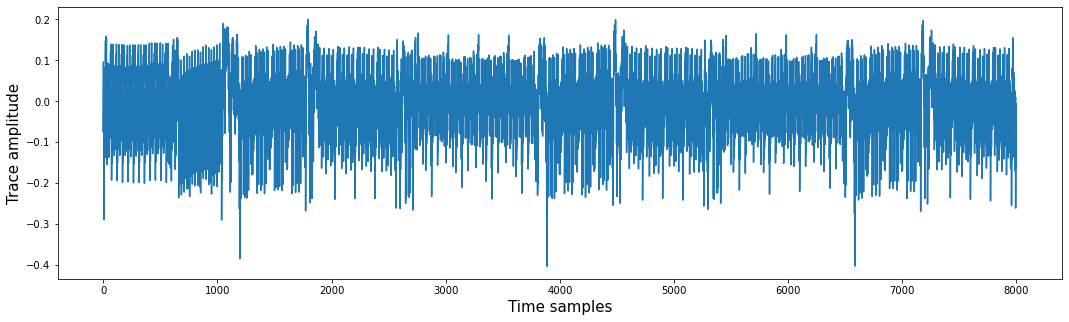

In [15]:
trace = ths[0].samples
fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(trace)
ax.set_xlabel('Time samples', fontsize=15)
ax.set_ylabel('Trace amplitude', fontsize=15)
plt.plot()

----
## Reverse on intermediate values - First round

In [44]:
import scared

In [8]:
# Write the selection function with scared to attack SB in first round
def aes_function_firstRde_SBout(plaintext, key):
    return ...
    
Selection_function = scared.reverse_selection_function(aes_function_firstRde_SBout)

In [9]:
# Place the traces in the container

In [10]:
# Prepare the reverse attack with scared

In [11]:
# run the attack

In [2]:
# display the dimension of result array

### 🫵 Your turn : Plot the result of the CPA reverse

❓ Questions
- Is there a leak? 


In [3]:
#plot the result of cpa reverse

# Resynchronization of traces

The attack worked when the traces were synchronized, and now the attack no longer works.

We need to resynchronize the traces. We observe the traces are only shifted, so a first basic resynchronisation by shifting the trace should be enough

💻[scipy doc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html#scipy.signal.find_peaks)

### 🫵 Your turn :  plot the absolute value for one trace

❓ Questions
- Can you observe any peaks?
- We are looking to set a peak detection threshold. What could be the value of the peak detection threshold?

In [14]:
trace_abs = np.abs(traces_np_array[0])

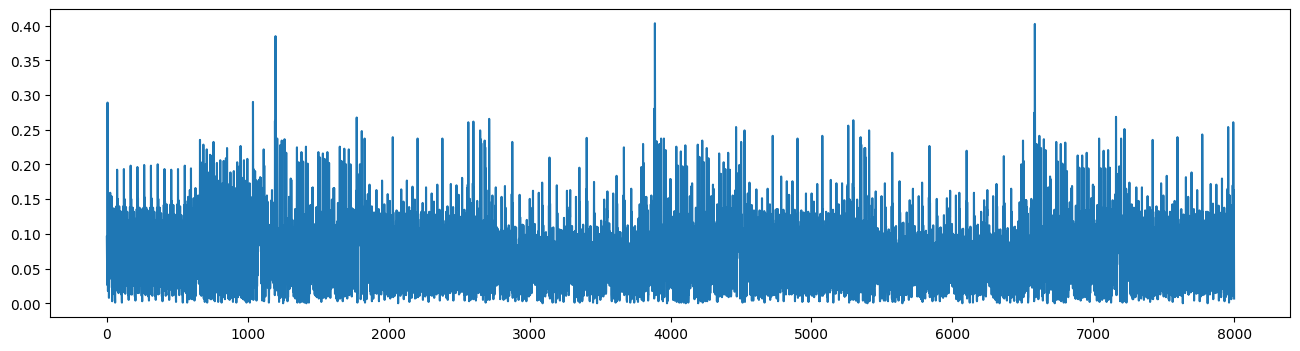

In [15]:
# plot your trace_abs

### 🫵 Your turn : Using scipy, find peaks with your threshold.

In [ ]:
#
peaks, _ = find_peaks(trace_abs, height = ....)
peaks

### 🫵 Your turn : plot the trace and his peaks

In [ ]:
# print the trace and the peaks
trace = traces_np_array[0]
plt.plot(trace)
plt.plot(peaks, trace[peaks], "x")
plt.show()

### 🫵 Your turn : Using the peaks to resync all traces. 

For each trace, detect a peak and keep points around that peak. You need to keep enough points to observe the operation to be attacked.

This method allows to shift traces on one peak.

<img src='images/resyn_traces.png' style='width: 300px'>

In [20]:
# Create a method that resyn all traces
trace_resync_list = []
for index in range(len(traces_np_array)):
    ...

### 🫵 Your turn : plot 5 resync traces

In [ ]:
# Plot 5 traces to check your resync
%matplotlib inline
...

In [22]:
traces_resynchronised = np.array(trace_resync_list)

# Trying CPA reverse on synchronized traces

### 🫵 Your turn : Using the previous cell in `Trying CPA reverse on desynchronized traces` to do CPA reverse

[estraces documentation](https://eshard.gitlab.io/estraces/estraces.html#id47)

> 💡**Tips**: read_ths_from_* allows you to create a `ths` from a source such as a file or RAM. Find the function that suits your needs. The **kwargs parameter requires a dictionary with the plaintext array, the ciphertext array, and the key array **{ “dict_key”:array_value,...} 

In [8]:
# Create a ths object with resync trace

### 🫵 Your turn: Print the ths information, the ths len

In [29]:
#create a container with your ths

In [30]:
# prepare the CPA reverse

In [31]:
# run the CPA reverse

In [9]:
# display the shape of the results

### 🫵 Your turn: Plotting the results of the reverse CPA
❓ Questions
- Is there a leak? 

In [10]:
#print the result

# Conclusion

In this case, the countermeasure has been bypassed. The addition of jitter must be better implemented to protect the AES implementation. It might also be worthwhile to add another countermeasure such as masking.